### Tensor Flow 2-11 notebook

Notes: 
- Notebook should be running with an Nvidia GPU to for top performance
- load_img will load a nparray with x, y, 3 color dims.  
- If we're just processing one image we will need to np.expand_dims(image, axies=0) to get 1, x, y, 3. The library expects N images in the first dim
- should set random seed on tf.random.set_seed(1) for reproduceability 
- 

last change 3/6/2025

In [1]:
# import the libraries for training, testing, validation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils  # will decode predictions out of the model into a 4 dim array of N (image num), imageID, label, probability result[0] would be the set of results for image one
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img  # will load img and reshape, usage is load_img(image_name_loc, target_size=input_shape)
from tensorflow.keras.utils import plot_model  # Note: usage syntax is plot_model(instantied_model, to_file='', show_shapes=True)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds  # For loading datasets from GCS

# import all model architectures
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.applications import InceptionV3


import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time


2025-03-16 17:42:35.831449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-16 17:42:36.624829: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-03-16 17:42:36.624917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

In [2]:
# define a dictionary for model config and experiment tracking.... 
model_input_variables = {
    "MobileNetV2": {
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
     "MobileNetV3Large": { #MobileNetV3 Large will be used to compare accuracy loss with small, prob not a candidate for rasp pi running
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
    "MobileNetV3Small":{ 
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
    "EfficientNetB0": {
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
    "InceptionV3": {
        "input_shape": (299, 299, 3),  # InceptionV3 typically uses 299x299
        "batch_size": 32,
    },
    "EfficientNetB7":{
        "input_shape": (600, 600, 3),  # big values!
        "batch_size": 16, # this is a larger model and the norm seems to be smaller batch sizes for reduced memory use
    }
}


In [3]:
# Experiment Configuration and globals
gcs_bucket = 'nabirds_filtered'  
dataset_path = 'images'  # Relative path within the bucket
default_batch_size = 32
default_image_size = (224, 224)

# experiment, make sure to increment the number
models_list = list(model_input_variables.keys())
run_experiments = {
    'experiment_number_1': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [0], # mobilenetv2 only
        'number_of_stages': 1, 
        'stage1': {'epochs': 5, 'trainable': False, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 2, 'trainable': True, 'trainable_layers': -2, 'learning_rate': 0.00001}
    }
}

In [4]:
print(f'Available models: {models_list}')
print(f'EfficientNetB0: {model_input_variables["EfficientNetB0"]}')
print(f'MobileNetV2: {model_input_variables["MobileNetV2"]}')
print(f'MobileNetV3Large: {model_input_variables["MobileNetV3Large"]}')
print(f'MobileNetV3Small: {model_input_variables["MobileNetV3Small"]}')
print(f'InceptionV3: {model_input_variables["InceptionV3"]}')
print(f'EfficientNetB7: {model_input_variables["EfficientNetB7"]}')

Available models: ['MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'EfficientNetB0', 'InceptionV3', 'EfficientNetB7']
EfficientNetB0: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV2: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Large: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Small: {'input_shape': (224, 224, 3), 'batch_size': 32}
InceptionV3: {'input_shape': (299, 299, 3), 'batch_size': 32}
EfficientNetB7: {'input_shape': (600, 600, 3), 'batch_size': 16}


In [5]:
def write_results_to_file(filename, experiment, start_time, end_time, model_name, epochs, 
                          training_accuracy, validate_accuracy, training_loss, validate_loss):
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    batch_size = model_input_variables[model_name]['batch_size']
    input_shape = model_input_variables[model_name]['input_shape']
    line = f'{experiment},{start_time_str},{end_time_str},{model_name},{batch_size},{epochs},{input_shape},{training_accuracy},' \
           f'{validate_accuracy},{training_loss},{validate_loss}\n'
    if not os.path.exists(filename):      # Check if the file exists, and add a header if it's new
        header = 'experiment,start_time,end_time,model_name,batch_size,epochs,input_shape,training_accuracy,validate_accuracy,training_loss,validate_loss\n'
        with open(filename, "w") as f:
            f.write(header + line)
    else:
        with open(filename, "a") as f: # or append to existing file
            f.write(line)
    print(f'experiment tracking updated')
    return

In [6]:
def load_images_gcs(bucket_name, dataset_path, model_image_size, model_batch_size):
    dataset = None
    gcs_dataset_path = f"gs://{bucket_name}/{dataset_path}"
    try:
        dataset = keras.utils.image_dataset_from_directory(gcs_dataset_path, image_size=model_image_size,
            batch_size=model_batch_size, label_mode='categorical',)  # categorical is for softmax layer
    except Exception as e:
        print(f'error loading dataset from gcs: {e}')    
    return dataset

In [7]:
# split into its own cell so we do not have to repeat this long operation, takes 10 minutes....
# need to run this each time for different image and batch sizes
def load_images(image_size=default_image_size, batch_size=default_batch_size):
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start loading images time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'Loading with image size of {image_size} and batch size of {batch_size}')

    train_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'train'), image_size, batch_size)
    validate_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'test'), image_size, batch_size)

    if train_dataset is None or validate_dataset is None:
        print(f'dataset loading failed.')
    return train_dataset, validate_dataset

In [8]:
def plot_training_results(acc, validate_acc, loss, validate_loss):
    epochs_plt = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_plt, acc, 'b', label='Training accuracy')
    plt.plot(epochs_plt, validate_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_plt, loss, 'b', label='Training loss')
    plt.plot(epochs_plt, validate_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

In [5]:
# lock and unlock layers, make this bullet proof so I don't have to think about the experiments too much
def lock_unlock_layers(model, train_last_x_layers):
    train_last_x_layers = 0 if train_last_x_layers == None else train_last_x_layers
    fine_tune_at = len(model.layers) - math.abs(train_last_x_layers)                        
    fine_tune_at = 0 if fine_tune_at < 0 else fine_tune_at
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True
    return model

In [ ]:
# load the default 224x224x3 ,batch size 32 data set.  do not loop over this code unless its an exception. 
# takes about 10 minutes
train_dataset, validate_dataset = load_images()
num_classes = len(train_dataset.class_names) # get class count, same no mater how the data is loaded given the same data set

Start loading images time: 2025-03-16 17:42:37
Loading with image size of (224, 224) and batch size of 32
Found 2455 files belonging to 27 classes.


2025-03-16 17:47:11.538838: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-03-16 17:47:11.538866: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-16 17:47:11.538884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bird-feeder-profiling-2024-2025): /proc/driver/nvidia/version does not exist
2025-03-16 17:47:11.539158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To ena

Found 621 files belonging to 27 classes.
Start time training and validation: 2025-03-16 17:48:20
building model: MobileNetV2 with 1 stage(s)
stage1 {'epochs': 5, 'trainable': False, 'trainable_layers': None, 'learning_rate': 0.0001}
epochs: 5
learning rate of 0.0001
Epoch 1/5
77/77 [==============================] - 88s 1s/step - loss: 3.3267 - accuracy: 0.0509 - val_loss: 3.2661 - val_accuracy: 0.0676
Epoch 2/5
77/77 [==============================] - 79s 943ms/step - loss: 3.0869 - accuracy: 0.1189 - val_loss: 3.2200 - val_accuracy: 0.0821
Epoch 3/5
77/77 [==============================] - 69s 816ms/step - loss: 2.9562 - accuracy: 0.1662 - val_loss: 3.1883 - val_accuracy: 0.0837
Epoch 4/5
77/77 [==============================] - 66s 788ms/step - loss: 2.8517 - accuracy: 0.2041 - val_loss: 3.1593 - val_accuracy: 0.1079
Epoch 5/5
77/77 [==============================] - 65s 783ms/step - loss: 2.7506 - accuracy: 0.2432 - val_loss: 3.1493 - val_accuracy: 0.1031


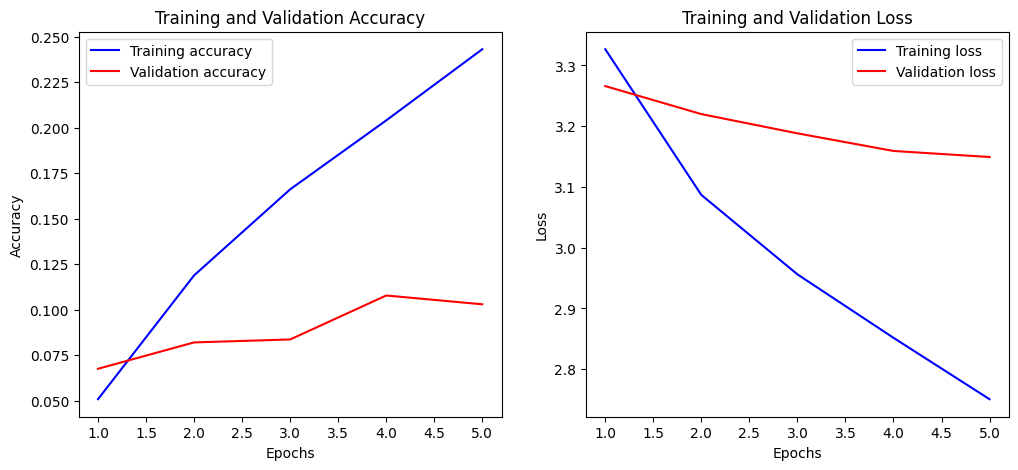

End time training and validation: 2025-03-16 17:54:28


In [9]:
# the experiments dictionary drives the model types and training parameters 
# loop over each model type, stages, and write out results of experiment to a file, save the model

for experiment in list(run_experiments.keys()):
    stages = run_experiments[experiment]['number_of_stages']
    stage1 = run_experiments[experiment]['stage1']
    stage1_learning = stage1["learning_rate"]
    stage1_epochs = stage1["epochs"]
    stage1_trainable = stage1['trainable']
    stage1_trainable_layers = stage1['trainable_layers']
    stage2 = run_experiments[experiment]['stage2']
    stage2_learning = stage2["learning_rate"]
    stage2_epochs = stage2["epochs"]
    stage2_trainable = stage2['trainable']
    stage2_trainable_layers = stage2['trainable_layers']
    
    for model_num in run_experiments[experiment]['model_types']:
        start_time = time.time()
        start_time_datetime = datetime.datetime.fromtimestamp(start_time)
        print(f'Start time training and validation: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
        model_name = models_list[model_num]
        print(f'building model: {model_name} with {stages} stage(s)')
        print(f'stage1... ')
        print(f'epochs: {stage1_epochs}')
        print(f'learning rate of {stage1_learning}')
        print(f'trainable: {stage1_trainable}')
        print(f'trainable_layers: {stage1_trainable_layers}')

        # load each mode type and modify head for softmax replacement
        if model_name == 'MobileNetV2':
            base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

        #####  setup stage 1 of X #####
        base_model.trainable = stage1_trainable  # lock or unlock the base model for transfer learning
        base_model = lock_unlock_layers(model=base_model, train_last_x_layers=stage1_trainable_layers)
        x = base_model.output  # start adding custom layers
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)  
        predictions = Dense(num_classes, activation='softmax')(x)

        # create the model with rescaling layer, this will automatically normalize the images within the model, bulletproofs feeder code
        # normalize pixel values to [0, 1], not sure if this was done in the old mobilenetv2 model
        inputs = base_model.input
        rescaled_inputs = tf.keras.layers.Rescaling(1./255)(inputs)  
        x = base_model(rescaled_inputs) # pass rescaled input through the base model
        model = Model(inputs=inputs, outputs=predictions) # use original inputs, this is weird, but how it was done in tutorial...

        # compile and train model, epoch zero is starting place for first stage, categorical crossentropy is for multi-class classification
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage1_learning), loss='categorical_crossentropy', metrics=['accuracy'])
        history_phase1 = model.fit(train_dataset, epochs=stage1_epochs, initial_epoch=0, validation_data=validate_dataset)  
                
        ##### setup stage 2 if requested
        combined_history = {}
        if stages == 2:
            model = lock_unlock_layers(model=model, train_last_x_layers=stage2_trainable_layers)
            # Recompile the model and continue from phase1, last epoch + 1 to move to next available 
            model.compile(optimizer=Adam(learning_rate=stage2_learning), loss='categorical_crossentropy', metrics=['accuracy'])
            history_phase2 = model.fit(train_dataset, epochs=stage2_epochs, initial_epoch=history_phase1.epoch[-1] + 1, 
                                       validation_data=validate_dataset)   
            
            for key in history_phase1.history:  # combine history
                combined_history[key] = history_phase1.history[key] + history_phase2.history[key]
        else:
            combined_history = history_phase1  # if one state take stage 1 hist
        
        #### process results and save model
        # record training time
        end_time = time.time()
        end_time_datetime = datetime.datetime.fromtimestamp(end_time)
        print(f'End time training and validation: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

        total_epochs = stage1_epochs + stage2_epochs
        model_filename = experiment + model_name
        model.save(f'{model_filename}.h5')  # save the model
        
        # write_results_to_file
        acc = combined_history.history['accuracy']
        validate_acc = combined_history.history['val_accuracy']
        loss = combined_history.history['loss']
        validate_loss = combined_history.history['val_loss']
        
        write_results_to_file('experiment_log.csv', experiment, start_time, end_time, model_name, total_epochs, acc, validate_acc, loss, validate_loss):
        plot_training_results(acc, validate_acc, loss, validate_loss) 


In [10]:
# sample predictions
# small_img = image.load_img(img_path, target_size=(224, 224))
# small_img_array = image.img_to_array(small_img)
# small_img_array = np.expand_dims(small_img_array, axis=0)
# small_img_array = preprocess_input(small_img_array)
# small_predictions = model_small.predict(small_img_array)
# decoded_small_predictions = decode_predictions(small_predictions, top=1)[0]
# print(decoded_small_predictions)

In [11]:
### old dead code.... 

In [13]:
# Sample Code for MobilenetV2
##### MobileNetV2 training sample, use for comparision to old model in feeder
# start_time = time.time()
# start_time_datetime = datetime.datetime.fromtimestamp(start_time)
# print(f'Start time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

# ###### load mobilenetv2 and modify head
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # unlock top layer for softmax replacement
# base_model.trainable = True  # Unlock the base model, note this should be changed to freeze some layers per lit review ??

# # add custom layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)  # Optional: Add more dense layers
# predictions = Dense(num_classes, activation='softmax')(x)

# # create the model with Rescaling layer
# inputs = base_model.input
# rescaled_inputs = tf.keras.layers.Rescaling(1./255)(inputs)  # normalize pixel values to [0, 1], not sure if this was done in the old mobilenetv2 model
# x = base_model(rescaled_inputs) # pass the rescaled input through the base model
# model = Model(inputs=inputs, outputs=predictions) # use the original inputs, this is weird, but how it was done in tutorial...

# # compile model
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',  # Important for multi-class classification
#               metrics=['accuracy'])

# # train the model
# history = model.fit(train_dataset, epochs=epochs, initial_epoch=0, validation_data=validation_dataset)  # initial epoch=0 is traing from scratch

# # save model
# model.save('mobilenet_retrained.h5')

# # plot results, error here means model did not train
# acc = history.history['accuracy']
# test_acc = history.history['val_accuracy']
# loss = history.history['loss']
# test_loss = history.history['val_loss']

# epochs_plt = range(1, len(acc) + 1)
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_plt, acc, 'b', label='Training accuracy')
# plt.plot(epochs_plt, test_acc, 'r', label='Test accuracy')
# plt.title('Training and Testing Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs_plt, loss, 'b', label='Training loss')
# plt.plot(epochs_plt, test_loss, 'r', label='Test loss')
# plt.title('Training and Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # record training time
# end_time = time.time()
# end_time_datetime = datetime.datetime.fromtimestamp(end_time)
# print(f'End time: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
